In [1]:
import numpy as np
import pandas as pd
from tpot import TPOTClassifier

from dask.distributed import Client
from sklearn.metrics import SCORERS, confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score
import joblib
import matplotlib.pyplot as plt

In [2]:
def get_df_from_default():
    df_temp = pd.read_csv("data/base.csv", sep=';')

    df_temp = df_temp[df_temp['Curso'] == 'Biologia']

    df = df_temp[['VAR01', 'VAR02', 'VAR03', 'VAR04', 'VAR05',
                  'VAR06', 'VAR07', 'VAR08', 'VAR09', 'VAR10',
                  'VAR12', 'VAR14', 'VAR15', 'VAR16', 'VAR17',
                  'VAR18', 'VAR19', 'VAR20', 'VAR21', 'VAR22',
                  'VAR23', 'VAR24', 'VAR25', 'VAR28', 'VAR30',
                  'VAR31', 'VAR31b', 'VAR31c', 'VAR32a', 'VAR32b',
                  'VAR32c', 'VAR32d', 'VAR33', 'VAR34', 'VAR35', 'DESEMPENHO_BINARIO']]

    df = df.rename(columns={"DESEMPENHO_BINARIO": "Y"})

    df["VAR17"] = df["VAR17"].astype(str).replace(',','.')
    df["VAR24"] = df["VAR24"].astype(str).replace(',','.')
    df["VAR25"] = df["VAR25"].astype(str).replace(',','.')
    df["VAR30"] = df["VAR30"].astype(str).replace(',','.')

    df["VAR17"] = df["VAR17"].astype(float)
    df["VAR24"] = df["VAR24"].astype(float)
    df["VAR25"] = df["VAR25"].astype(float)
    df["VAR30"] = df["VAR30"].astype(float)
    
    return df

In [3]:
def get_df_from_fmdev():
    df = pd.read_csv("../backend/data/raw/94ca2547-88c4-4c10-9446-c71a09dc579e.csv")
    
#     df_categoric = df.copy()
#     df_categoric = df_categoric.select_dtypes(include=['object'])
#     df = df.drop(df_categoric.columns, axis=1)
#     del df['id_do_aluno']

        
    
#     df = df[['var01', 'var02', 'var03', 'var04', 'var05',
#                   'var06', 'var07', 'var08', 'var09', 'var10',
#                   'var12', 'var14', 'var15', 'var16', 'var17',
#                   'var18', 'var19', 'var20', 'var21', 'var22',
#                   'var23', 'var24', 'var25', 'var28', 'var30',
#                   'var31', 'var31b', 'var31c', 'var32a', 'var32b',
#                   'var32c', 'var32d', 'var33', 'var34', 'var35', 'desempenho_binario']]

#     df = df.rename(columns={"desempenho_binario": "y"})

#     df["var17"] = df["var17"].astype(str).replace(',','.')
#     df["var24"] = df["var24"].astype(str).replace(',','.')
#     df["var25"] = df["var25"].astype(str).replace(',','.')
#     df["var30"] = df["var30"].astype(str).replace(',','.')

#     df["var17"] = df["var17"].astype(float)
#     df["var24"] = df["var24"].astype(float)
#     df["var25"] = df["var25"].astype(float)
#     df["var30"] = df["var30"].astype(float)
    
    return df

In [3]:
def get_split(df, target):
    msk = np.random.rand(len(df)) < 0.7

    train = df[msk]
    test = df[~msk]

    Y_test = test[target]
    X_test = test.drop(labels = [target],axis = 1)

    Y_train = train[target]
    X_train = train.drop(labels = [target],axis = 1)
    
    return X_train, Y_train, X_test, Y_test

In [4]:
df = get_df_from_default()
X_train, Y_train, X_test, Y_test = get_split(df, 'Y')

In [5]:
# connect to the cluster
client = Client(processes=False) 

# create the estimator normally
estimator = TPOTClassifier(generations=5, max_time_mins=5, population_size=20, cv=5,
                                    random_state=42, verbosity=3, 
                                    use_dask=True,
                                    periodic_checkpoint_folder="data/tpot-output/")

# perform the fit in this context manager
with joblib.parallel_backend("dask"):
    estimator.fit(X_train, Y_train)

31 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Negative values in data passed to MultinomialNB (input X).
Generation 1 - Current Pareto front scores:
-1	0.8885935769656699	RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=True, RandomForestClassifier__criterion=gini, RandomForestClassifier__max_features=0.45, RandomForestClassifier__min_samples_leaf=9, RandomForestClassifier__min_samples_split=3, RandomForestClassifier__n_estimators=100)
-2	0.8899224806201552	XGBClassifier(ZeroCount(input_matrix), XGBClassifier__learning_rate=0.1, XGBClassifier__max_depth=7, XGBClassifier__min_child_weight=20, XGBClassifier__n_estimators=100, XGBClassifier__nthread=1, XGBClassifier__subsample=0.6000000000000001)

Saving periodic pipeline from pareto front to data/tpot-output/pipeline_gen_1_idx_0_2020.04.15_19-02-07.py
Saving periodic pipeline 

In [6]:
estimator.score(X_test, Y_test)

0.9055196419691696

In [7]:
best_pipeline = estimator.fitted_pipeline_

precision = SCORERS['precision'](best_pipeline, X_test, Y_test)
recall = SCORERS['recall'](best_pipeline, X_test, Y_test)
roc_auc = SCORERS['roc_auc'](best_pipeline, X_test, Y_test)

In [8]:
precision

0.9108433734939759

In [9]:
recall

0.8669724770642202

In [10]:
roc_auc

0.9688297919469034

In [11]:
Y_pred = estimator.predict(X_test)

In [12]:
confusion_matrix(Y_test, Y_pred)

array([[1065,   74],
       [ 116,  756]])

[[0.93503073 0.06496927]
 [0.13302752 0.86697248]]


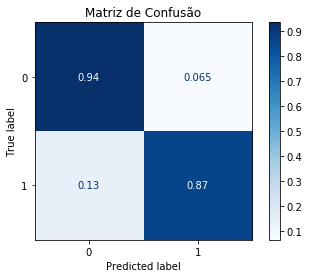

In [13]:
disp = plot_confusion_matrix(estimator.fitted_pipeline_, X_test, Y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues,
                                 normalize="true")
disp.ax_.set_title('Matriz de Confusão')

print(disp.confusion_matrix)

In [14]:
lr_probs = estimator.predict_proba(X_test)[:,1]

ns_probs = [0 for _ in range(len(Y_test))]
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)

In [15]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.969


In [16]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

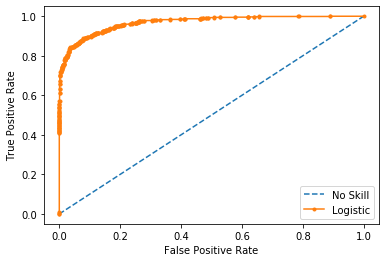

In [17]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()